<a href="https://colab.research.google.com/github/rifahtasnia/Air-Canada-Seat-choice-prediction/blob/master/Air_Canada_seat_choice_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



# Dataset Loading and Feature extraction

In [ ]:
participant_data_path = '/content/participant_data.csv'
participant_data = pd.read_csv(participant_data_path)

participant_data = participant_data[participant_data['choice'].notnull()]
participant_data['flight_departure_datetime'] = pd.to_datetime(participant_data['flight_departure_datetime'], errors='coerce')
participant_data['purchase_datetime'] = pd.to_datetime(participant_data['purchase_datetime'], errors='coerce')

# Feature extraction
participant_data['departure_month'] = participant_data['flight_departure_datetime'].dt.strftime('%y%m').astype(int)
participant_data['purchase_month'] = participant_data['purchase_datetime'].dt.strftime('%y%m').astype(int)
participant_data['advs_inventory_ratio'] = participant_data['ADVS_inventory'] / participant_data['ADVS_capacity']
participant_data['pref_inventory_ratio'] = participant_data['PREF_inventory'] / participant_data['PREF_capacity']
participant_data['total_inventory_ratio'] = participant_data['advs_inventory_ratio'] + participant_data['pref_inventory_ratio']
choice_mapping = {'advs': 1, 'pref': 2, 'nochoice': 0}
participant_data['choice_map'] = participant_data['choice'].map(choice_mapping).astype(int)
participant_data['dep_dow_id'] = participant_data['flight_departure_datetime'].dt.dayofweek
participant_data['purchweeks_before_depart'] = ((participant_data['flight_departure_datetime'] - participant_data['purchase_datetime']).dt.days / 7).astype(int)

# Define extracted features
extracted_features = participant_data[['departure_month', 'purchase_month', 'trip_type', 'branded_fare', 'number_of_pax',
                                       'ADVS_price', 'PREF_price', 'advs_inventory_ratio', 'pref_inventory_ratio',
                                       'total_inventory_ratio', 'purchweeks_before_depart', 'choice_map']]

features = ['departure_month', 'purchase_month', 'trip_type', 'branded_fare', 'number_of_pax',
            'ADVS_price', 'PREF_price', 'advs_inventory_ratio', 'pref_inventory_ratio',
            'total_inventory_ratio', 'purchweeks_before_depart']
target = 'choice_map'
X = extracted_features[features]
y = extracted_features[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



# Hyperparameter tuning and Model training

In [ ]:
# Hyperparameter tuning using RandomizedSearchCV
random_param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1200, num=12)],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


base_rf = RandomForestClassifier(random_state=42)


random_search = RandomizedSearchCV(estimator=base_rf, param_distributions=random_param_grid,
                                   n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1, scoring='f1_weighted')


random_search.fit(X_train, y_train)

# Get the best parameters from the random search
best_random_params = random_search.best_params_
best_random_score = random_search.best_score_
print(f"Best Random Parameters: {best_random_params}")
print(f"Best Random Search Score: {best_random_score}")

# Train the optimized model using best parameters
optimized_rf_model = RandomForestClassifier(random_state=42, class_weight='balanced', **best_random_params)
optimized_rf_model.fit(X_train, y_train)


y_pred_optimized = optimized_rf_model.predict(X_test)



Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Random Parameters: {'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 80, 'bootstrap': True}
Best Random Search Score: 0.7127005947724422


# Evaluate Model

Optimized Model Accuracy: 0.7184155844155844
Optimized Model F1 Score: 0.7203692831247607
Classification Report for Optimized Model:
               precision    recall  f1-score   support

           0       0.86      0.83      0.84     26178
           1       0.42      0.36      0.39      6666
           2       0.47      0.64      0.54      5656

    accuracy                           0.72     38500
   macro avg       0.58      0.61      0.59     38500
weighted avg       0.73      0.72      0.72     38500



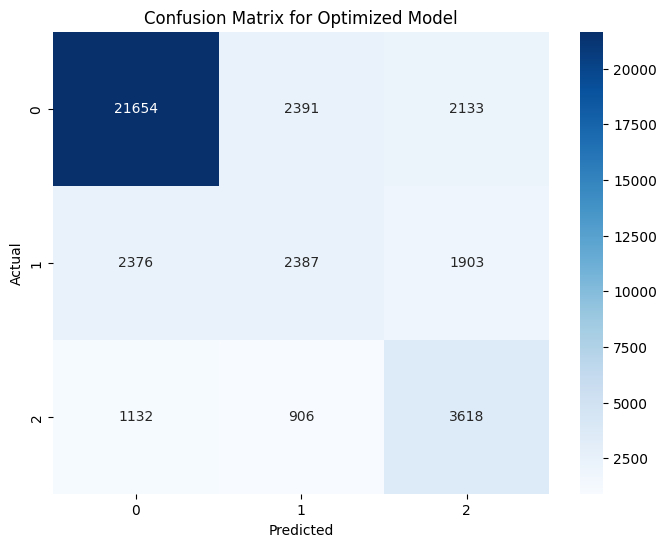

In [ ]:
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
f1_optimized = f1_score(y_test, y_pred_optimized, average='weighted')
class_report_optimized = classification_report(y_test, y_pred_optimized)
conf_matrix_optimized = confusion_matrix(y_test, y_pred_optimized)


print(f"Optimized Model Accuracy: {accuracy_optimized}")
print(f"Optimized Model F1 Score: {f1_optimized}")
print("Classification Report for Optimized Model:\n", class_report_optimized)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_optimized, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Confusion Matrix for Optimized Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Choice prediction for the baseline file

In [ ]:
baseline_data_path = '/content/baseline.csv'
baseline_data = pd.read_csv(baseline_data_path)
baseline_data_final = pd.read_csv(baseline_data_path)

In [ ]:
baseline_data['flight_departure_datetime'] = pd.to_datetime(baseline_data['flight_departure_datetime'])
baseline_data['purchase_datetime'] = pd.to_datetime(baseline_data['purchase_datetime'])

baseline_data['departure_month'] = baseline_data['flight_departure_datetime'].dt.strftime('%y%m').astype(int)
baseline_data['purchase_month'] = baseline_data['purchase_datetime'].dt.strftime('%y%m').astype(int)

baseline_data['advs_inventory_ratio'] = baseline_data['ADVS_inventory'] / baseline_data['ADVS_capacity']
baseline_data['pref_inventory_ratio'] = baseline_data['PREF_inventory'] / baseline_data['PREF_capacity']
baseline_data['total_inventory_ratio'] = baseline_data['advs_inventory_ratio'] + baseline_data['pref_inventory_ratio']

baseline_data['dep_dow_id'] = baseline_data['flight_departure_datetime'].dt.dayofweek
baseline_data['purchweeks_before_depart'] = ((baseline_data['flight_departure_datetime'] - baseline_data['purchase_datetime']).dt.days / 7).astype(int)

X_missing = baseline_data[features]
baseline_data['Predicted choice'] = optimized_rf_model.predict(X_missing)


output_df = baseline_data[['id', 'Predicted choice']]


#output_file = "/content/predicted_units.csv"
#output_df.to_csv(output_file, index=False)

# Replace the missing 'Units' values in the original dataset with the predictions
baseline_data.loc[baseline_data['choice'].isnull(), 'choice'] = baseline_data['Predicted choice']

print(baseline_data.columns)


final_dataset_path = "/content/participant_data_with_predictions.csv"
baseline_data.to_csv(final_dataset_path, index=False)

final_dataset_path


Index(['id', 'ticket_id', 'od', 'flight_departure_datetime',
       'purchase_datetime', 'trip_type', 'branded_fare', 'number_of_pax',
       'ADVS_price', 'PREF_price', 'ADVS_capacity', 'PREF_capacity',
       'ADVS_inventory', 'PREF_inventory', 'choice', 'departure_month',
       'purchase_month', 'advs_inventory_ratio', 'pref_inventory_ratio',
       'total_inventory_ratio', 'dep_dow_id', 'purchweeks_before_depart',
       'Predicted choice'],
      dtype='object')


'/content/participant_data_with_predictions.csv'

In [ ]:
predicted_data_path = '/content/participant_data_with_predictions.csv'
predicted_data = pd.read_csv(predicted_data_path)

choice_mapping = {1: 'advs', 2: 'pref', 0: 'nochoice'}


print("Columns in baseline_data:", baseline_data.columns)

if 'Predicted choice' not in predicted_data.columns:
    raise KeyError("'Predicted choice' column not found in predicted_data. Please check the column name or file.")


predicted_data['Predicted choice'] = predicted_data['Predicted choice'].map(choice_mapping)

id_to_predicted_choice = dict(zip(predicted_data['id'], predicted_data['Predicted choice']))


baseline_data_final['choice'] = baseline_data_final['id'].map(id_to_predicted_choice)


baseline_data_final.to_csv("baseline_data_final.csv", index=False)


Columns in baseline_data: Index(['id', 'ticket_id', 'od', 'flight_departure_datetime',
       'purchase_datetime', 'trip_type', 'branded_fare', 'number_of_pax',
       'ADVS_price', 'PREF_price', 'ADVS_capacity', 'PREF_capacity',
       'ADVS_inventory', 'PREF_inventory', 'choice', 'departure_month',
       'purchase_month', 'advs_inventory_ratio', 'pref_inventory_ratio',
       'total_inventory_ratio', 'dep_dow_id', 'purchweeks_before_depart',
       'Predicted choice'],
      dtype='object')
